In [1]:
from Levenshtein import distance, ratio, jaro
import json
import numpy as np
np.set_printoptions(edgeitems=6, linewidth=160)
import re

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, fcluster
from scipy.spatial.distance import squareform

In [2]:
#load organids
with open('../output/organids.json','r') as f:
    organids = json.load(f)
    
#load base history
with open('../output/history_base.json', 'r') as f:
    hist_base = json.load(f)
    
#load changes
with open('../output/history_projects.json', 'r') as f:
    hist_projects = json.load(f)

#collect all builder names
builders = []
for organid in organids:
    if len(hist_base[organid]['builder']) > 0:
        builders.append(hist_base[organid]['builder'])
    for changes in hist_projects[organid]:
        if len(changes['name']) > 0:
            builders.append(changes['name'])

In [367]:
#only keep uniq
builders = list(set(builders))

In [368]:
#throw out 'met gebruikmaking van ...'
builders = [b.split('met gebruikmaking')[0] for b in builders]

In [369]:
#throw out vermoedelijk, waarschijnlijk, mogelijk
builders = [b.replace('vermoedelijk','').replace('mogelijk','').replace('waarschijnlijk','').replace('wellicht','') for b in builders]

In [370]:
#split on 'en', ',', and '/'
builders_tmp = []
for b in builders:
    res = re.split(r' en |, |(?<=[^v])/|in samenwerking met| of ', b)
    for r in res:
        builders_tmp.append(r.strip())

builders = builders_tmp

In [371]:
#only keep uniq
builders = list(set(builders))

In [322]:
#expand initials
re_initial = re.compile(r'((?<=[^a-zA-Z])[a-zA-Z]\.|^[a-zA-Z]\.)')

for ix, b in enumerate(builders):
    matches = [(m.start(0), m.end(0)) for m in re.finditer(re_initial, b)]
    for start, end in reversed(matches):
        b = b[:start+1] + b[start].lower()*2 + b[end-1:]
    builders[ix] = b
    

In [372]:
#throw out entries of length 0
builders = [b for b in builders if len(b) > 0]

In [373]:
bcount = len(builders)

In [374]:
distmat = np.zeros((bcount, bcount))

In [375]:
lengths = np.array([[len(b) for b in builders]])

In [376]:
minlengths = np.minimum(lengths.T, lengths)

In [377]:
normalization = lengths.T + lengths

In [378]:
normalization

array([[28, 25, 19, 31, 27, 23, ..., 29, 29, 23, 24, 36, 27],
       [25, 22, 16, 28, 24, 20, ..., 26, 26, 20, 21, 33, 24],
       [19, 16, 10, 22, 18, 14, ..., 20, 20, 14, 15, 27, 18],
       [31, 28, 22, 34, 30, 26, ..., 32, 32, 26, 27, 39, 30],
       [27, 24, 18, 30, 26, 22, ..., 28, 28, 22, 23, 35, 26],
       [23, 20, 14, 26, 22, 18, ..., 24, 24, 18, 19, 31, 22],
       ...,
       [29, 26, 20, 32, 28, 24, ..., 30, 30, 24, 25, 37, 28],
       [29, 26, 20, 32, 28, 24, ..., 30, 30, 24, 25, 37, 28],
       [23, 20, 14, 26, 22, 18, ..., 24, 24, 18, 19, 31, 22],
       [24, 21, 15, 27, 23, 19, ..., 25, 25, 19, 20, 32, 23],
       [36, 33, 27, 39, 35, 31, ..., 37, 37, 31, 32, 44, 35],
       [27, 24, 18, 30, 26, 22, ..., 28, 28, 22, 23, 35, 26]])

In [386]:
for i in range(len(builders)):
    if i%100 == 0:
        print (i, end=' ')
    for j in range(len(builders)):
        distmat[i,j] = 1 - jaro(builders[i], builders[j])

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 

normalized edit distance:

https://stackoverflow.com/questions/45783385/normalizing-the-edit-distance

http://www.cse.lehigh.edu/%7Elopresti/Publications/1996/sdair96.pdf

In [387]:
normalized_distmat = distmat #/ normalization

In [388]:
condensed_normalized_distmat = squareform(normalized_distmat)

In [389]:
Z = linkage(condensed_normalized_distmat, method='centroid')

In [390]:
clusterids = fcluster(Z, 0.7)

In [391]:
builder_sets = {}
for ix, cid in enumerate(clusterids):
    if cid not in builder_sets.keys():
        builder_sets[cid] = set()
    builder_sets[cid].add(ix)

for cid in builder_sets.keys():
    print("\n--------------------\n")
    for ix in list(builder_sets[cid]):
        print(builders[ix])


--------------------

H.F.C. Leichel

--------------------

F. Chr. de Vries
F. de Vries

--------------------

Flaes
P. Flaes
Ottes
Gottlieb Früh?

--------------------

Cornelis Gerritsz

--------------------

J.H. Stinkens
J. Stinkens

--------------------

Niehoff?)

--------------------

N. Smits
J. Smits
L. Smits

--------------------

W. Sauer Orgelbauanstalt
W. Sauer

--------------------

J. van Nieuwkerk

--------------------

C.C. Bender

--------------------

Adema’s Kerkorgelbouw
Adema´s Kerkorgelbouw

--------------------

oorspronkelijk kabinetorgel

--------------------

J. Reil (aanvankelijk)

--------------------

Carl Philipp König

--------------------

G. Robustelly
J. Rousseau

--------------------

M. Renshaw
Martin Renshaw

--------------------

Jos. Vermeulen fa L Ypma & Co.

--------------------

C. Haupt & Sohn

--------------------

B. Koch
B.Koch

--------------------

Schölgens & Van der Weijde
Schöltgens & Van der Weyde

--------------------

R.Ancion
D.

In [274]:
#for i in leaves_list(Z):
#    print(builders[i])

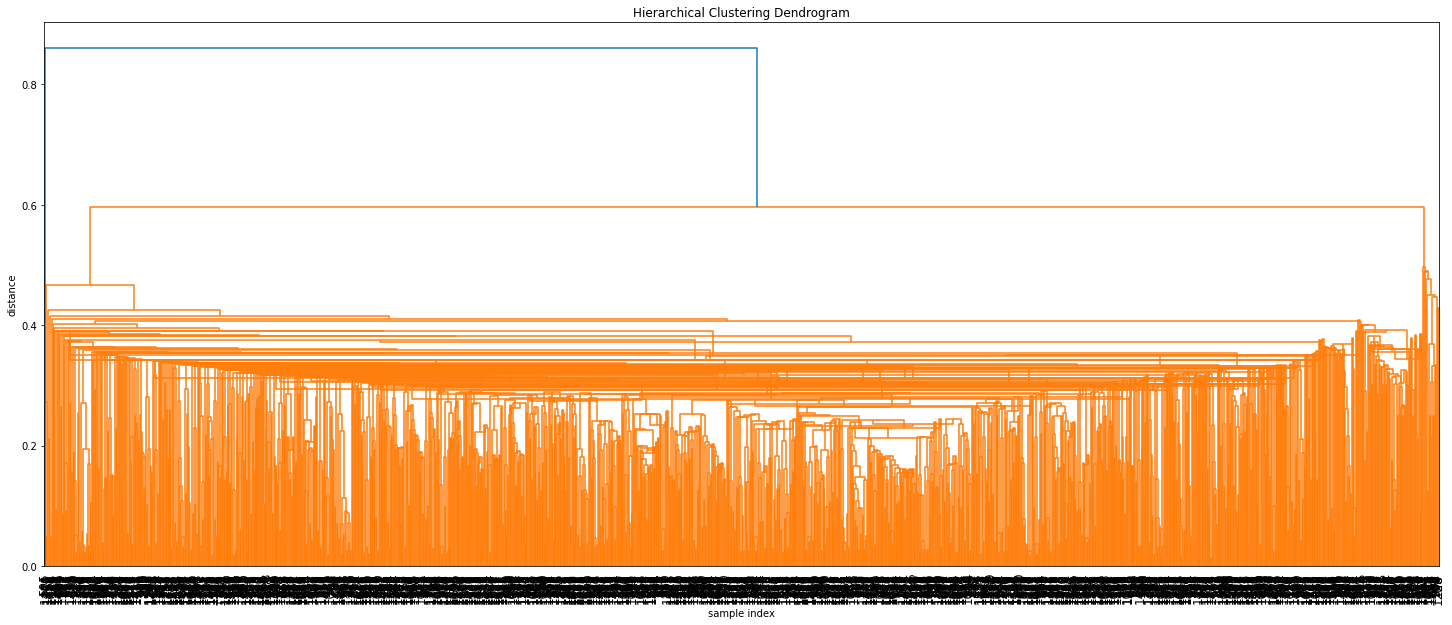

In [270]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
H = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
)
plt.show()

### Using disamby

In [240]:
import pandas as pd
import disamby.preprocessors as pre
from disamby import Disamby

In [241]:
df = pd.DataFrame({
    'name': builders
})

In [242]:
len(builders)

1567

In [243]:
pipeline = [
    pre.normalize_whitespace,
    #pre.remove_punctuation,
    lambda x: pre.trigram(x) + pre.split_words(x)
]

In [244]:
dis = Disamby(df, pipeline)

In [247]:
builder_sets = dis.disambiguated_sets(threshold=0.4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [00:12<00:00, 125.34it/s]


In [248]:
for s in builder_sets:
    print("\n--------------------\n")
    for ix in list(s):
        print(builders[ix])


--------------------

Hhhhh.Fffff.Ccccc. Leichel

--------------------

Fffff. Chr. de Vries

--------------------

Erven Pieter de Vries

--------------------

Wwwww.Eeeee. Modderkolk (firma Gebr. van Vulpen) met plaatselijke vrijwilligers

--------------------

fa Spanjaard met plaatselijke vrijwilligers

--------------------

Fffff. de Vries

--------------------

Eeeee.Rrrrr. Ottes

--------------------

Rrrrr. Ottes
Ottes

--------------------

Cornelis Gerritsz
Peter Gerritsz

--------------------

Jjjjj.Hhhhh. Stinkens
Jjjjj. Stinkens

--------------------

Niehoff?)

--------------------

Johann Christoff Scheuer

--------------------

Jan Christoffel Smit
Christoffel Bätz
Jan Christoffel Schmidt

--------------------

Gebr. Nnnnn.Lllll. & Fffff.Ccccc. Smits

--------------------

Wwwww. Smits (Utrecht)

--------------------

Lllll. Smits (Cuijk)

--------------------

Fffff.Ccccc. (III) Smits

--------------------

Wwwww.Jjjjj. Smits

--------------------

Gebr. Hhhhh.Wwwww.J